In [88]:
#https://www.tensorflow.org/tutorials/structured_data/time_series

In [1]:
import os
os.chdir("/Users/jacksonwalters/Documents/GitHub/enefit-kaggle/predict-energy-behavior-of-prosumers/")
!ls

client.csv                            gas_prices.csv
county_id_to_name_map.json            historical_weather.csv
electricity_prices.csv                public_timeseries_testing_util.py
enefit                                train.csv
example_test_files                    weather_station_to_county_mapping.csv
forecast_weather.csv


In [2]:
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [3]:
#load the training data, dropping NaN's
df = pd.read_csv("train.csv").dropna()

In [4]:
#helper function to convert strings to integers representing a time
from datetime import datetime
def datestr_to_int(datetime_str):
    return datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S').timestamp()

In [5]:
df['datetime'] = df['datetime'].apply(datestr_to_int)

In [6]:
df.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,1.630469e+09,0,0,0
1,0,0,1,96.590,1,1.630469e+09,0,1,0
2,0,0,2,0.000,0,1.630469e+09,0,2,1
3,0,0,2,17.314,1,1.630469e+09,0,3,1
4,0,0,3,2.904,0,1.630469e+09,0,4,2


In [7]:
#test-train-validation split on the data
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [8]:
#normalize the training data
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

/var/folders/4d/rp7dhwss6znf18sks0v304d80000gn/T/ipykernel_1156/2075556950.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(df.keys(), rotation=90)


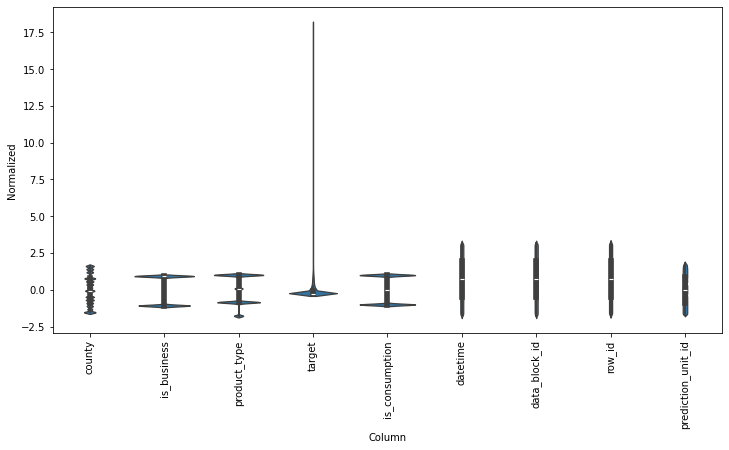

In [12]:
#peak at the normalized data
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [13]:
#Handle the indexes and offsets as shown in the diagrams above.
#Split windows of features into (features, labels) pairs.
#Plot the content of the resulting windows.
#Efficiently generate batches of these windows from the training, evaluation, and test data, using tf.data.Datasets.
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [14]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['target'])

In [15]:
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['target']

In [16]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['target'])

In [17]:
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['target']

In [18]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [19]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

Metal device set to: Apple M1
All shapes are: (batch, time, features)
Window shape: (3, 7, 9)
Inputs shape: (3, 6, 9)
Labels shape: (3, 1, 1)


2023-12-10 20:42:06.129336: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-10 20:42:06.129846: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [20]:
w2.example = example_inputs, example_labels

In [21]:
def plot(self, model=None, plot_col='target', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

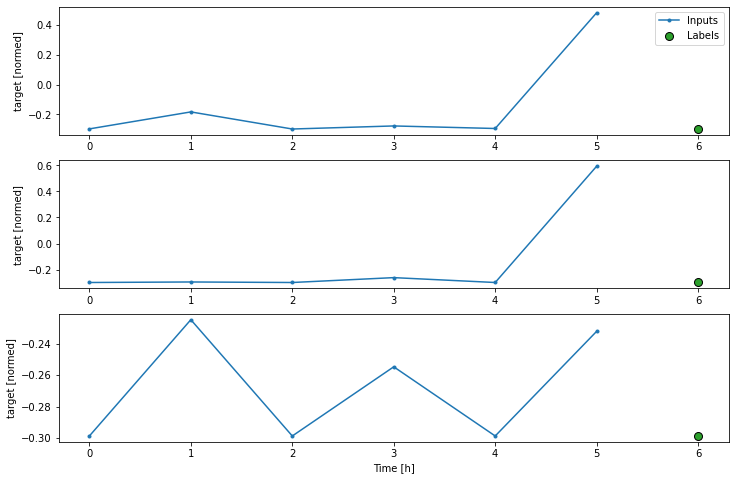

In [22]:
w2.plot()

In [23]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [24]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [25]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 9), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [26]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 9)
Labels shape (batch, time, features): (32, 1, 1)


2023-12-10 20:42:25.132644: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [27]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['target'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['target']

In [28]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 9)
Labels shape (batch, time, features): (32, 1, 1)


In [29]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [30]:
baseline = Baseline(label_index=column_indices['target'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

   33/12612 [..............................] - ETA: 40s - loss: 3.9638 - mean_absolute_error: 0.7691  

2023-12-10 20:42:34.297752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12612/12612 [==============================] - 41s 3ms/step - loss: 3.5724 - mean_absolute_error: 0.7404


In [31]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['target'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['target']

In [32]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 9)
Output shape: (32, 24, 1)


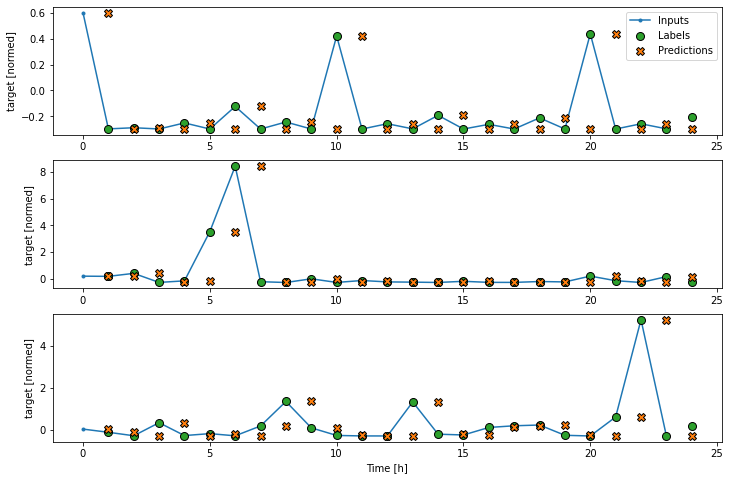

In [33]:
wide_window.plot(baseline)

In [34]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [35]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 9)
Output shape: (32, 1, 1)


In [36]:
MAX_EPOCHS = 1

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [52]:
history = compile_and_fit(linear, single_step_window)

   19/44140 [..............................] - ETA: 4:15 - loss: 0.9837 - mean_absolute_error: 0.4170  

2023-12-10 17:18:10.124494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


44138/44140 [============================>.] - ETA: 0s - loss: 0.8902 - mean_absolute_error: 0.3999

2023-12-10 17:22:05.827096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


44140/44140 [==============================] - 276s 6ms/step - loss: 0.8903 - mean_absolute_error: 0.3999 - val_loss: 1.4505 - val_mean_absolute_error: 0.4298


In [53]:
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

12612/12612 [==============================] - 49s 4ms/step - loss: 1.4505 - mean_absolute_error: 0.4298


In [54]:
#stack a few dense layers between input and output
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

2023-12-10 17:25:29.707881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


44140/44140 [==============================] - ETA: 0s - loss: 0.1909 - mean_absolute_error: 0.1829

2023-12-10 17:31:56.793789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12612/12612 [==============================] - 76s 6ms/step - loss: 0.3068 - mean_absolute_error: 0.2840


In [ ]:
history = compile_and_fit(dense, single_step_window)

In [ ]:
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

In [60]:
#un-normalize the mean-absolute-error
(train_std['target'] * history.history['mean_absolute_error'][0] ) + train_mean['target']

404.95756995595696

In [62]:
#multi-step dense network
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['target'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['target']

Text(0.5, 1.0, 'Given 3 time-units of inputs, predict 1 time-unit into the future.')

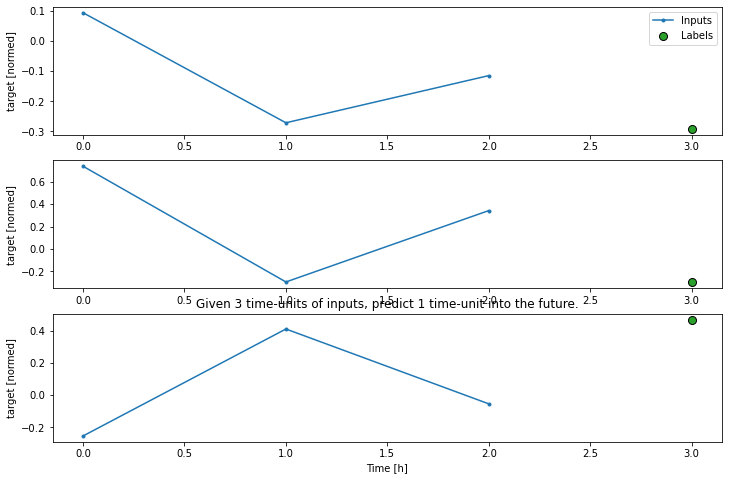

In [64]:
conv_window.plot()
plt.title("Given 3 time-units of inputs, predict 1 time-unit into the future.")

In [65]:
#define the model architechture
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [66]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 9)
Output shape: (32, 1, 1)


In [67]:
#train the model
history = compile_and_fit(multi_step_dense, conv_window)

2023-12-10 17:40:44.864265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


44140/44140 [==============================] - ETA: 0s - loss: 0.1282 - mean_absolute_error: 0.1635

2023-12-10 17:45:08.522185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


44140/44140 [==============================] - 300s 7ms/step - loss: 0.1282 - mean_absolute_error: 0.1635 - val_loss: 0.3935 - val_mean_absolute_error: 0.2408


In [69]:
IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

12612/12612 [==============================] - 45s 4ms/step - loss: 0.3935 - mean_absolute_error: 0.2408


In [82]:
#un-normalize the mean absolute error
(train_std['target'] * history.history['mean_absolute_error'][0] ) + train_mean['target']

388.68397030412365

In [83]:
#convolutional neural network
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [84]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 9)
Output shape: (32, 1, 1)


In [85]:
history = compile_and_fit(conv_model, conv_window)

2023-12-10 17:52:30.771576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


44140/44140 [==============================] - ETA: 0s - loss: 0.1230 - mean_absolute_error: 0.1572

2023-12-10 17:58:29.674597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


44140/44140 [==============================] - 419s 9ms/step - loss: 0.1230 - mean_absolute_error: 0.1572 - val_loss: 0.3231 - val_mean_absolute_error: 0.2148


In [86]:
IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

12612/12612 [==============================] - 72s 6ms/step - loss: 0.3231 - mean_absolute_error: 0.2148


In [87]:
#un-normalize the mean absolute error
(train_std['target'] * history.history['mean_absolute_error'][0] ) + train_mean['target']

383.34228630272133

In [37]:
#recurrent neural network
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [38]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 9)
Output shape: (32, 24, 1)


In [39]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

12611/12611 [==============================] - 110s 9ms/step - loss: 0.2821 - mean_absolute_error: 0.1979


In [9]:
#un-normalize the mean absolute error
(train_std['target'] * .1979 ) + train_mean['target']

417.5693961986801